In [1]:
#P100 Ram: 16G
# !nvidia-smi

In [2]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.6 MB/s eta 0:00:00


In [3]:
import os
import time
from tqdm import tqdm
import numpy as np
import zipfile
import PIL
import gc
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import captum

# ResNet Training

In [4]:
class Timer:
    def __init__(self, message):
        self.message = message
        self.st_time = time.time()
        
    def end(self):
        end_time = time.time()
        elapsed_time = end_time-self.st_time
        print(f'{self.message} process took {elapsed_time//60}min, {elapsed_time%60:.2f}sec')        
        

In [5]:
def img_resize(files,path):
    img_to_numpy = []
#     for file in tqdm(files):
    for file in files:
        file_img = PIL.Image.open(f"{path}/{file}")
        file_img = file_img.resize((224, 224))
        img_to_numpy.append(np.array(file_img))
    return np.array(img_to_numpy)

def data_split(img_data):
    x_train, x_val = train_test_split(img_data, test_size = 0.2, random_state=42)
    x_train, x_test = train_test_split(x_train, test_size = 0.2, random_state=42)
    print(f'train: {x_train.shape}, val: {x_val.shape}, test: {x_test.shape}')
    return x_train, x_val, x_test

In [6]:
#  Load Dataset and Unzip
timer_unzip = Timer("Data Unzip")
base_path = '/kaggle/input/dogs-vs-cats'
filelist = os.listdir('/kaggle/input/dogs-vs-cats')
for _file in filelist:
    if '.zip' in _file:
        with zipfile.ZipFile(os.path.join(base_path, _file), 'r') as z:
            z.extractall('/kaggle/working')
timer_unzip.end()

Data Unzip process took 0.0min, 13.62sec


In [7]:
# Split Cat and Dog
timer_datasplit = Timer("Data Split")
train_files = os.listdir("/kaggle/working/train")
cat_files = sorted([file for file in train_files if file.split(".")[0] == "cat"], key=lambda x: int(x.split(".")[1]))
dog_files = sorted([file for file in train_files if file.split(".")[0] == "dog"], key=lambda x: int(x.split(".")[1]))
timer_datasplit.end()

Data Split process took 0.0min, 0.05sec


In [8]:
# From Total 25000, Random Sampling 6250 imgs
# needs Seed Setting
timer_randomsampling = Timer("Data Random Sampling")
np.random.seed(42)
cat_random_sample = np.random.choice(cat_files, 6250) # array
dog_random_sample = np.random.choice(dog_files, 6250) # array
print(f"cat img count {cat_random_sample.shape}, dog img count {dog_random_sample.shape}")
timer_randomsampling.end()

cat img count (6250,), dog img count (6250,)
Data Random Sampling process took 0.0min, 0.01sec


In [9]:
# Image Resize
timer_img_resize = Timer("Image Resize")
numpy_cat = img_resize(cat_random_sample, "/kaggle/working/train")
numpy_dog = img_resize(dog_random_sample, "/kaggle/working/train")
# numpy_cat = img_resize(cat_files, "/kaggle/working/train")
# numpy_dog = img_resize(dog_files, "/kaggle/working/train")
timer_img_resize.end()

Image Resize process took 0.0min, 44.19sec


In [10]:
# Train, Val, Test Split
timer_split = Timer("Train, Val, Test Split")
train_cat, val_cat, test_cat = data_split(numpy_cat)
train_dog, val_dog, test_dog = data_split(numpy_dog)

# Memory manage
del numpy_cat, numpy_dog
gc.collect()
timer_split.end()

train: (4000, 224, 224, 3), val: (1250, 224, 224, 3), test: (1000, 224, 224, 3)
train: (4000, 224, 224, 3), val: (1250, 224, 224, 3), test: (1000, 224, 224, 3)
Train, Val, Test Split process took 0.0min, 1.10sec


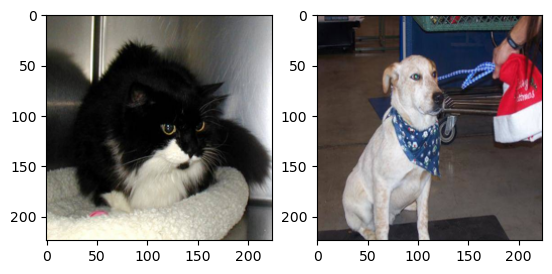

In [11]:
plt.subplot(1, 2, 1)
plt.imshow(train_cat[3])
plt.subplot(1, 2, 2)
plt.imshow(train_dog[3])
plt.show()

In [12]:
# image numpy shape (batch, height, width, channel) -> image torch shape (batch, channel, height, width)
# train_tensor_im.permute(0, 2, 3, 1) -> image numpy shape (batch, height, width, channel)

timer_img_transform = Timer("Concatenate and Transfrom")
train_img = np.concatenate((train_cat, train_dog))
train_tensor_img = torch.stack([transforms.ToTensor()(img) for img in train_img])
train_tensor_label = torch.LongTensor([0]*len(train_cat) + [1]*len(train_dog))

val_img = np.concatenate((val_cat, val_dog))
val_tensor_img = torch.stack([transforms.ToTensor()(img) for img in val_img])
val_tensor_label = torch.LongTensor([0]*len(val_cat) + [1]*len(val_dog))

test_img = np.concatenate((test_cat, test_dog))
test_tensor_img = torch.stack([transforms.ToTensor()(img) for img in test_img])
test_tensor_label = torch.LongTensor([0]*len(test_cat) + [1]*len(test_dog))

del train_cat, train_dog, val_cat, val_dog, test_cat, test_dog
del train_img, val_img, test_img
gc.collect()
timer_img_transform.end()

Concatenate and Transfrom process took 0.0min, 10.31sec


In [13]:
# Make Batch Sized Dataset for Training
train_dataset = TensorDataset(train_tensor_img, train_tensor_label)
train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle=True)

val_dataset = TensorDataset(val_tensor_img, val_tensor_label)
val_dataloader = DataLoader(val_dataset, batch_size = 128, shuffle=True)

test_dataset = TensorDataset(test_tensor_img, test_tensor_label)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle=True)

del train_dataset, val_dataset, test_dataset
gc.collect()

0

In [14]:
# Load ResNet50 Model From torchvision
model = models.resnet50(weights="IMAGENET1K_V2")

# Revise Linear Layer into 2 Classes
model.fc = nn.Linear(2048,2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 280MB/s]


In [15]:
loss_fn =  nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
def training(model, train_dataloader, loss_fn, optimizer, device):
    train_loss = 0.0
    train_y, train_pred = [], []
    model.train()
    for x, y in train_dataloader:
        optimizer.zero_grad()
        pred = model(x.to(device))
        loss = loss_fn(pred, y.to(device))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_y.extend(y.detach().cpu().tolist())
        train_pred.extend(torch.argmax(pred, axis=1).detach().cpu().tolist())
    train_f1_score = f1_score(train_y, train_pred)
    return train_loss, train_f1_score    

In [17]:
def validation(model, val_dataloader, loss_fn, device):
    val_loss = 0.0
    val_y, val_pred = [], []
    
    model.eval()
    with torch.no_grad():
        for x, y in val_dataloader:
            pred = model(x.to(device))
            loss = loss_fn(pred, y.to(device))
            val_loss += loss.item()

            val_y.extend(y.detach().cpu().tolist())
            val_pred.extend(torch.argmax(pred, axis=1).detach().cpu().tolist())
    
    val_f1_score = f1_score(val_y, val_pred)
    return val_loss, val_f1_score   

In [18]:
def test(model, ckpt_path, test_dataloader, device):
    model.load_state_dict(torch.load(ckpt_path))
    model = model.to(device)
    
    val_loss = 0.0
    test_y, test_pred = [], []
    
    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            pred = model(x.to(device))
            loss = loss_fn(pred, y.to(device))
            val_loss += loss.item()

            test_y.extend(y.detach().cpu().tolist())
            test_pred.extend(torch.argmax(pred, axis=1).detach().cpu().tolist())
    test_f1_score = f1_score(test_y, test_pred)
    return test_f1_score   

In [19]:
# ResNet18: val f1 about 70 
def train_process(epochs, model, loss_fn, optimizer, train_dataloader, val_dataloader, test_dataloader, device):
    best_loss, patience = float('inf'), 0
    
    # make ckpt saving directory 
    if not os.path.exists('/kaggle/working/ckpt'):
        os.makedirs('/kaggle/working/ckpt', exist_ok=True)
        
    for epoch in range(epochs):
        train_st_time=time.time()
        train_loss, train_f1 = training(model, train_dataloader, loss_fn, optimizer, device)
        val_loss, val_f1 = validation(model, val_dataloader, loss_fn, device)
        
        # Best Save Only
        if val_loss < best_loss:
            patience = 0
            best_loss = val_loss
            ckpt_path = '/kaggle/working/ckpt/ft_resnet50.pt'
            torch.save(model.state_dict(), ckpt_path)
        
        # Early Stopping
        elif val_loss >= best_loss:
            patience += 1
            if patience == 50:
                break
                print(f'Eearly Stopped {epoch}')
                
        print(f'epoch: {epoch:3d}, train loss: {train_loss:8.4f}, valid loss: {val_loss:8.4f}, train f1 score: {train_f1*100:8.4f}, val f1 score: {val_f1*100:8.4f}, patience: {patience:2d}, time: {(time.time()-train_st_time):5.2f}')
    
    test_f1 = test(model, ckpt_path, test_dataloader, device) 
    print()
    print(f"Test F1 Score: {test_f1:8.4f}")
        
    

In [20]:
epochs = 1000
loss_fn =  nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_process(epochs, model, loss_fn, optimizer, train_dataloader, val_dataloader, test_dataloader, device)

epoch:   0, train loss:   8.1612, valid loss:   0.4333, train f1 score:  95.3795, val f1 score:  99.2006, patience:  0, time: 47.03
epoch:   1, train loss:   0.4700, valid loss:   0.4826, train f1 score:  99.8000, val f1 score:  99.3181, patience:  0, time: 42.35
epoch:   2, train loss:   0.3387, valid loss:   0.2728, train f1 score:  99.8376, val f1 score:  99.5598, patience:  1, time: 42.39
epoch:   3, train loss:   0.2496, valid loss:   0.4110, train f1 score:  99.9125, val f1 score:  99.3224, patience:  1, time: 42.34
epoch:   4, train loss:   0.3282, valid loss:   0.3064, train f1 score:  99.8125, val f1 score:  99.6399, patience:  2, time: 42.35
epoch:   5, train loss:   0.0664, valid loss:   0.2817, train f1 score:  99.9875, val f1 score:  99.6399, patience:  3, time: 42.35
epoch:   6, train loss:   0.0384, valid loss:   0.3311, train f1 score:  99.9875, val f1 score:  99.6003, patience:  4, time: 42.34
epoch:   7, train loss:   0.0244, valid loss:   0.3142, train f1 score:  99.

In [21]:
del train_dataloader, val_dataloader
gc.collect()
torch.cuda.empty_cache()

In [22]:
with open('/kaggle/working/test_dataloader.pickle', 'wb') as f:
    pkl.dump(test_dataloader, f, protocol=pkl.HIGHEST_PROTOCOL)

# Xai

In [ ]:
def print_label(number):
    dict_label = {0:'cat', 1:'dog'}
    print(f'label of Image: {dict_label[test_y[number]]}, prediction of Image: {dict_label[test_pred[number]]}')

In [ ]:
test_dataloader = pkl.load(open('/content/kaggle/ckpt/test_dataloader.pickle', 'rb'))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load ResNet18 Model From torchvision
model = models.resnet50()
model.fc = nn.Linear(2048,2)
# model
model.load_state_dict(torch.load('/content/kaggle/ckpt/ft_resnet50.pt'))
model = model.to(device)

In [ ]:
timer_test_predict = Timer("test predict")
test_pred, test_y, test_img = [], [], []
model.eval()
with torch.no_grad():
    for x, y in test_dataloader:
        test_img.append(x)
        pred = model(x.to(device))
        pred = torch.argmax(pred, axis=1)
        test_pred.extend(pred.detach().cpu().tolist())
        test_y.extend(y.detach().cpu().tolist())

_test_img = torch.cat(test_img)
test_img = _test_img.permute(0, 2, 3, 1).detach().cpu().numpy()
timer_test_predict.end()

test predict process took 0.0min, 13.51sec


In [ ]:
f1_score(test_y, test_pred)

0.9955067398901647

label of Image: cat, prediction of Image: cat


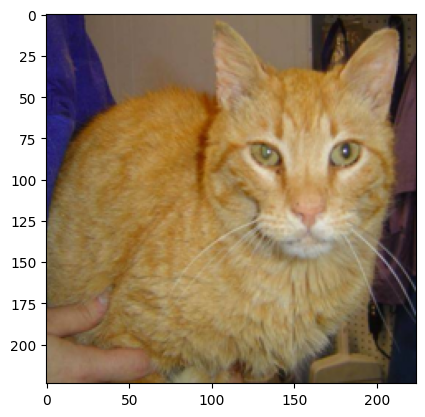

In [ ]:
number = 77
plt.imshow(test_img[number])
print_label(number)

In [ ]:
from captum.attr import Occlusion
from captum.attr import visualization as viz

In [ ]:
occlusion = Occlusion(model.to(device))
strides = (3, 3, 3)
target = test_pred[number]
sliding_window_shapes = (3, 9, 9)
baselines = 0

attribution_cat = occlusion.attribute(_test_img[number].unsqueeze(0).to(device),
                                     strides=strides,
                                     target=target,
                                     sliding_window_shapes=sliding_window_shapes,
                                     baselines=baselines)

In [ ]:
print(test_img[number].shape)
print(_test_img[number].unsqueeze(0).shape)

(224, 224, 3)
torch.Size([1, 3, 224, 224])


In [ ]:
# (channel, height, width) -> (height, width, channel)
np_attribution_cat = np.transpose(attribution_cat.squeeze(0).detach().cpu().numpy(), (1,2,0))
tranposed_img = test_img[number].squeeze()

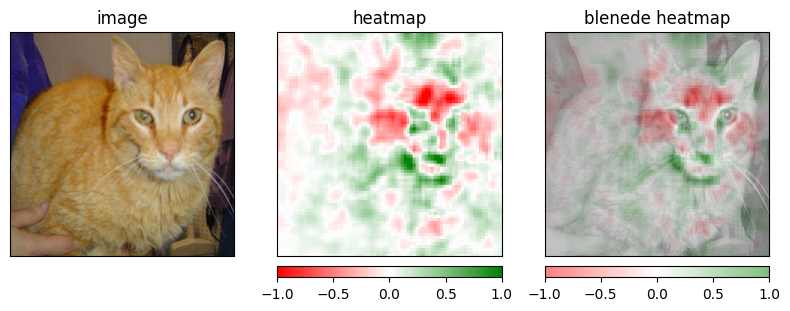

In [ ]:
_ = viz.visualize_image_attr_multiple(np_attribution_cat, # Image with Algorithm
                                      tranposed_img, # Original Image
                                      ["original_image", "heat_map", "blended_heat_map", ], # Image Type: 'original_image', 'heat_map', 'blended_heat_map' 
                                      ["all", "all", "all",], # Heatmap type: 'all',  'positive', 'negative'
                                      ["image", "heatmap", "blenede heatmap"], # Title
                                      show_colorbar=True)

label of Image: cat, prediction of Image: cat


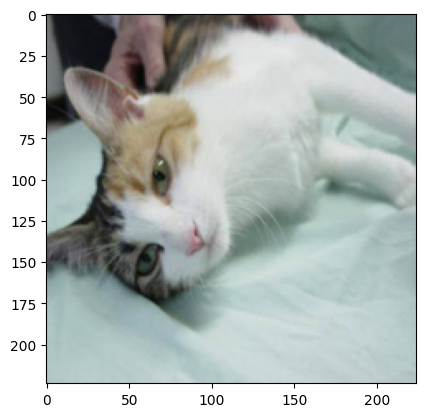

In [ ]:
number = 339
plt.imshow(test_img[number])
print_label(number)

In [ ]:
occlusion = Occlusion(model.to(device))
strides = (3, 3, 3)
target = test_pred[number]
sliding_window_shapes = (3, 9, 9)
baselines = 0

attribution_cat = occlusion.attribute(_test_img[number].unsqueeze(0).to(device),
                                     strides=strides,
                                     target=target,
                                     sliding_window_shapes=sliding_window_shapes,
                                     baselines=baselines)

In [ ]:
np_attribution_cat = np.transpose(attribution_cat.squeeze(0).detach().cpu().numpy(), (1,2,0))
tranposed_img = test_img[number].squeeze()

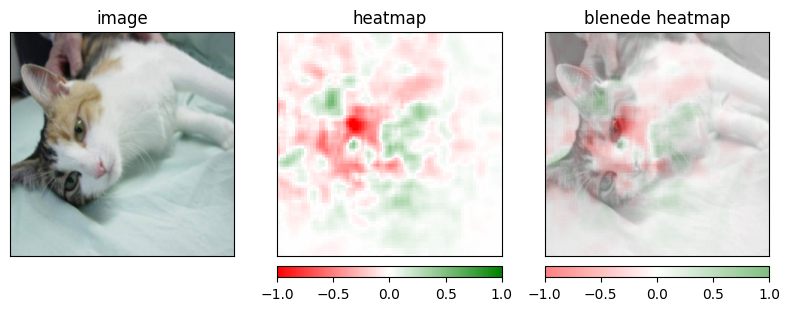

In [ ]:
_ = viz.visualize_image_attr_multiple(np_attribution_cat,
                                      tranposed_img,
                                      ["original_image", "heat_map", "blended_heat_map", ],
                                      ["all", "all", "all",],
                                      ["image", "heatmap", "blenede heatmap"],
                                      show_colorbar=True)

label of Image: dog, prediction of Image: dog


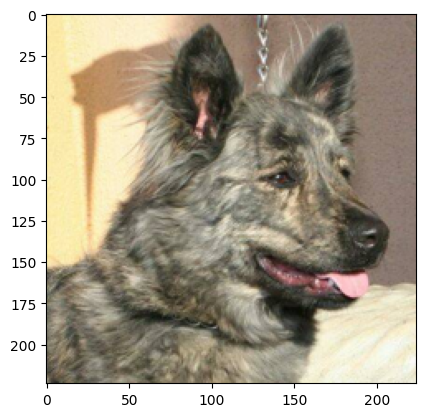

In [ ]:
number = 302
plt.imshow(test_img[number])
print_label(number)

In [ ]:
occlusion = Occlusion(model.to(device))
strides = (3, 3, 3)
target = test_pred[number]
sliding_window_shapes = (3, 9, 9)
baselines = 0

attribution_cat = occlusion.attribute(_test_img[number].unsqueeze(0).to(device),
                                     strides=strides,
                                     target=target,
                                     sliding_window_shapes=sliding_window_shapes,
                                     baselines=baselines)

In [ ]:
np_attribution_cat = np.transpose(attribution_cat.squeeze(0).detach().cpu().numpy(), (1,2,0))
tranposed_img = test_img[number].squeeze()

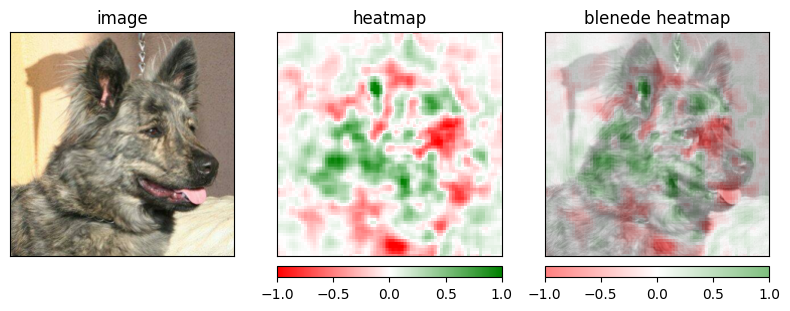

In [ ]:
_ = viz.visualize_image_attr_multiple(np_attribution_cat,
                                      tranposed_img,
                                      ["original_image", "heat_map", "blended_heat_map", ],
                                      ["all", "all", "all",],
                                      ["image", "heatmap", "blenede heatmap"],
                                      show_colorbar=True)

label of Image: dog, prediction of Image: dog


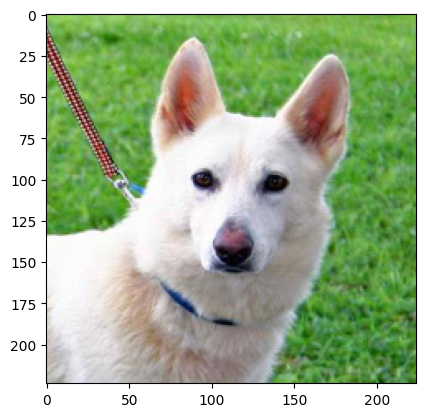

In [ ]:
number = 159
plt.imshow(test_img[number])
print_label(number)

In [ ]:
occlusion = Occlusion(model.to(device))
strides = (3, 3, 3)
target = test_pred[number]
sliding_window_shapes = (3, 9, 9)
baselines = 0

attribution_cat = occlusion.attribute(_test_img[number].unsqueeze(0).to(device),
                                     strides=strides,
                                     target=target,
                                     sliding_window_shapes=sliding_window_shapes,
                                     baselines=baselines)

In [ ]:
np_attribution_cat = np.transpose(attribution_cat.squeeze(0).detach().cpu().numpy(), (1,2,0))
tranposed_img = test_img[number].squeeze()

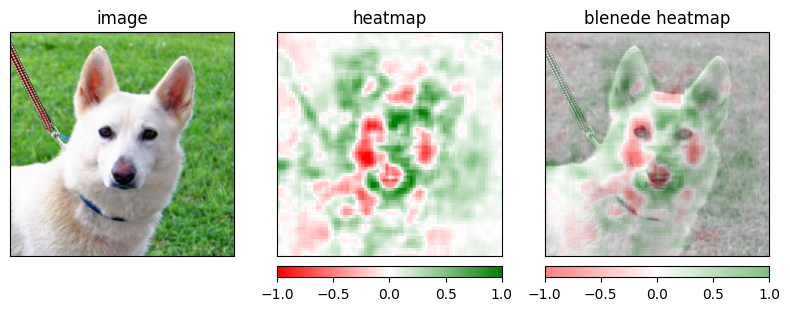

In [ ]:
_ = viz.visualize_image_attr_multiple(np_attribution_cat, 
                                      tranposed_img,
                                      ["original_image", "heat_map", "blended_heat_map", ],
                                      ["all", "all", "all",],
                                      ["image", "heatmap", "blenede heatmap"],
                                      show_colorbar=True)

label of Image: cat, prediction of Image: cat


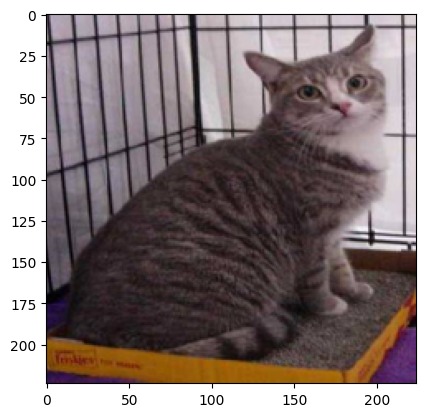

In [ ]:
number = 14
plt.imshow(test_img[number])
print_label(number)

In [ ]:
occlusion = Occlusion(model.to(device))
strides = (3, 3, 3)
target = test_pred[number]
sliding_window_shapes = (3, 9, 9)
baselines = 0

attribution_cat = occlusion.attribute(_test_img[number].unsqueeze(0).to(device),
                                     strides=strides,
                                     target=target,
                                     sliding_window_shapes=sliding_window_shapes,
                                     baselines=baselines)

In [ ]:
np_attribution_cat = np.transpose(attribution_cat.squeeze(0).detach().cpu().numpy(), (1,2,0))
tranposed_img = test_img[number].squeeze()

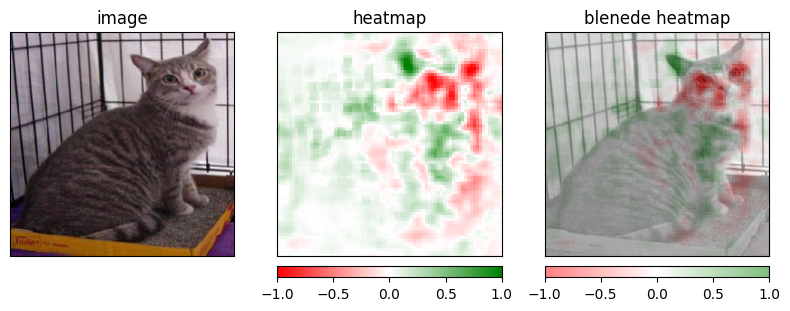

In [ ]:
_ = viz.visualize_image_attr_multiple(np_attribution_cat,
                                      tranposed_img,
                                      ["original_image", "heat_map", "blended_heat_map", ],
                                      ["all", "all", "all",],
                                      ["image", "heatmap", "blenede heatmap"],
                                      show_colorbar=True)